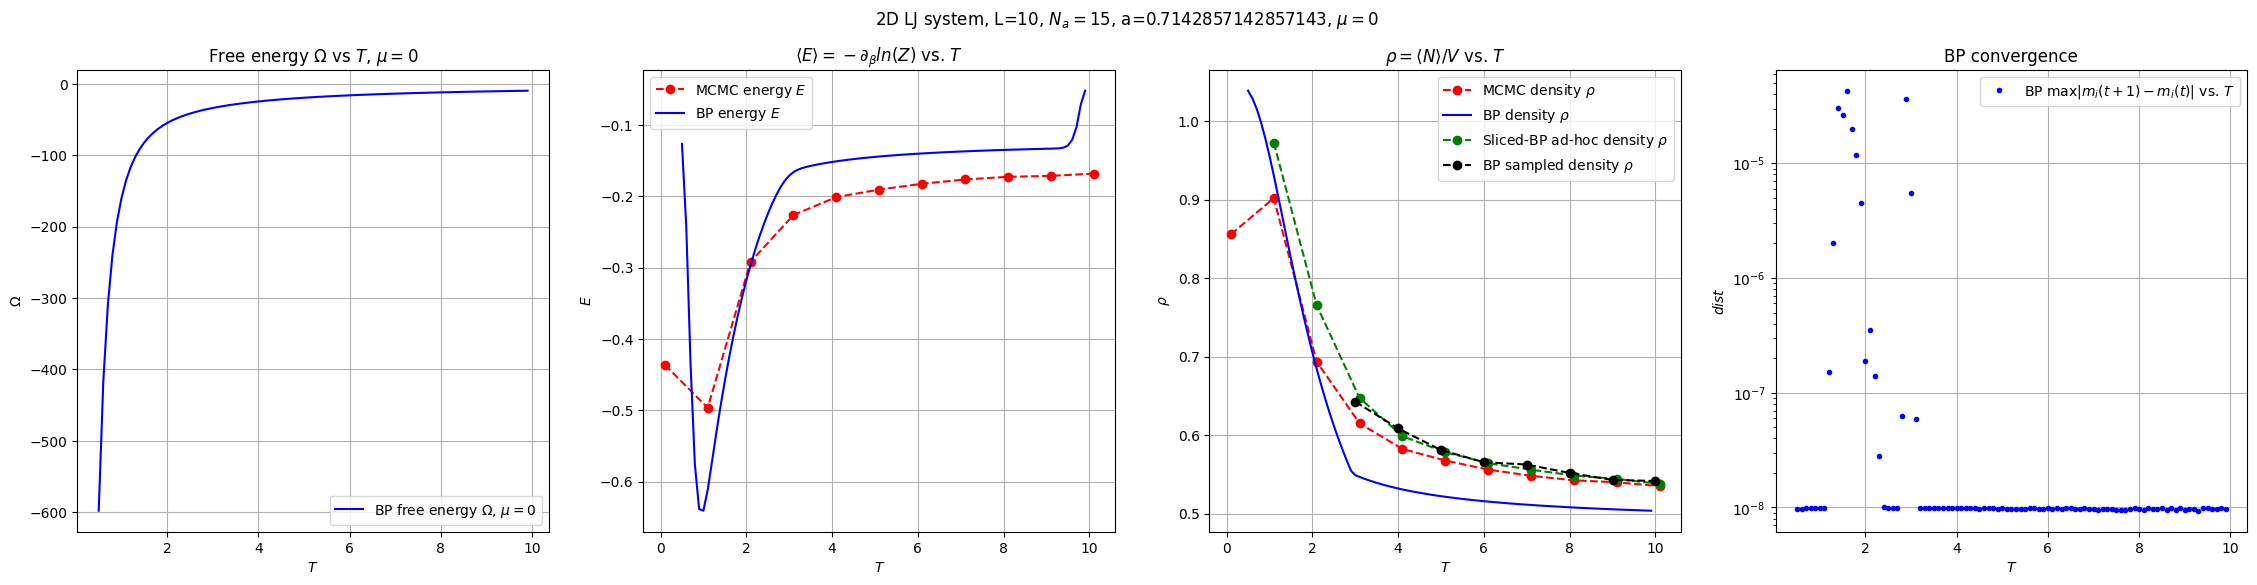

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.ndimage import gaussian_filter1d


import re

def extract_data(line):
    # Regex pattern to match key-value pairs
    # The pattern now accounts for spaces and special characters in keys
    pattern = r'([\w\s/]+)\s*=\s*([\w\.\-+e]+)'

    data_string = line

    # Find all matches
    matches = re.findall(pattern, data_string)

    # Convert matches to a list of dictionaries
    data = []
    current_dict = {}
    for key, value in matches:
        key = key.strip()  # Remove leading/trailing whitespaces from the key
        if key == 'T':  # New record starts when 'T' is found
            if current_dict:  # If there's a previous record, add it to the list
                data.append(current_dict)
                current_dict = {}
        try:
            # Convert numerical values to float or int
            if '.' in value or 'e' in value:
                current_dict[key] = float(value)
            else:
                current_dict[key] = int(value)
        except ValueError:
            # Keep as string if conversion fails
            current_dict[key] = value

    # Add the last record
    if current_dict:
        data.append(current_dict)

    # # Print the extracted data
    # for record in data:
    #     print(record)

    return data

# a = 0.9
# N_a = 10
# L = (N_a-1) * a

def plot_data(a, L, N_a, input_sigma=0, mcmc=True):
    N = N_a**2
    V = L**2
    # TN

    # Read from file
    f = open(f"./BP/Results/2DLJ_occ_L={L}_N_a={N_a}_results_pbc.txt", "r")
    lines = f.readlines()
    f.close()

    T_bp, free_entropy_bp, converged, max_dm, damping, density_bp, mu = [], [], [], [], [], [], []

    for line in lines:
        if line.startswith('T'):
            data = extract_data(line)
            T_bp.append(data[0]['T'])
            free_entropy_bp.append(data[0]['Entropy'])
            converged.append(data[0]['Converged'])
            max_dm.append(data[0]['Max dm'])
            damping.append(data[0]['damping'])
            density_bp.append(data[0]['BP density N/V'])
            mu.append(data[0]['chemical potential'])

    T_bp = np.array(T_bp)
    free_entropy_bp = np.array(free_entropy_bp)
    density_bp = np.array(density_bp)
    mu = np.array(mu)
    damping = np.array(damping)
    max_dm = np.array(max_dm)
    converged = np.array(converged)

    # sort the data
    idx = T_bp.argsort()
    T_bp = T_bp[idx]
    free_entropy_bp = free_entropy_bp[idx]
    density_bp = density_bp[idx]
    mu = mu[idx]
    damping = damping[idx]
    max_dm = max_dm[idx]
    converged = converged[idx]

    total_number_bp = density_bp * V

    # Selct data with chemical potential == 0
    idx = np.where(mu == 0)
    T_bp = T_bp[idx]
    free_entropy_bp = free_entropy_bp[idx]
    density_bp = density_bp[idx]
    mu = mu[idx]
    damping = damping[idx]
    max_dm = max_dm[idx]
    converged = converged[idx]

    # Smoothify data
    free_energy_bp = -free_entropy_bp / T_bp # Actually the grand potential in grand canonical ensemble
    if input_sigma != 0:
        sigma = input_sigma
        free_entropy_bp = gaussian_filter1d(free_entropy_bp, sigma)
    dFdT_bp = np.gradient(free_entropy_bp, T_bp)
    S = -np.gradient(free_energy_bp, T_bp)
    T_bp_sq = T_bp**2
    energy_bp = T_bp_sq * dFdT_bp / N

    # MC
    if mcmc:
        # Read from file
        f = open(f"./MC/Results/2DLJ_occ_L={L}_N_a={N_a}_results_pbc.txt", "r")
        lines = f.readlines()
        f.close()

        T_mc, energy_mc, density_mc, mu_mc = [], [], [], []

        for line in lines:
            if line.startswith('T'):
                data = extract_data(line)
                T_mc.append(data[0]['T'])
                energy_mc.append(data[0]['Energy'])
                density_mc.append(data[0]['Occupation Number']*N/V)
                mu_mc.append(data[0]['chemical potential'])


    # Plot

    fig, ax = plt.subplots(1, 4, figsize=(28, 6))
    ax[0].plot(T_bp, free_energy_bp, label=r'BP free energy $\Omega$, $\mu=0$',color='b')

    ax[0].set_xlabel(r'$T$')
    ax[0].set_ylabel(r'$\Omega$')
    ax[0].set_title(r'Free energy $\Omega$ vs $T$, $\mu=0$')
    ax[0].legend()
    ax[0].grid()

    
    if mcmc:
        ax[1].plot(T_mc, energy_mc, '--o',label=r'MCMC energy $E$',color='r')
    ax[1].plot(T_bp, energy_bp, '-',label=r'BP energy $E$',color='b')
    ax[1].set_xlabel(r'$T$')
    ax[1].set_ylabel(r'$E$')
    ax[1].set_title(r'$\langle E \rangle = -\partial_\beta ln(Z)$ vs. $T$')
    ax[1].legend()
    ax[1].grid()

    
    if mcmc:
        ax[2].plot(T_mc, density_mc, '--o', label=r'MCMC density $\rho$',color='r')
    ax[2].plot(T_bp, density_bp, '-',label=r'BP density $\rho$',color='b')
    
    if N_a==15 and L==10:
        t_sliced = [1.1, 2.1, 3.1, 4.1, 5.1, 6.1, 7.1, 8.1, 9.1, 10.1]
        sliced_rho = [0.9728328560661786, 0.7655665853571082, 0.6474003180021499, 0.5985949647645257, 0.5782821495200905,0.5642408174210102,0.5559778725528415,0.5484643373448275,0.5441651586445106,0.5378168415290628]
        ax[2].plot(t_sliced, sliced_rho, '--o', label=r'Sliced-BP ad-hoc density $\rho$',color='g')
        t_sampled = [3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0]
        sampled_rho = [0.6426666666666667,0.6084999999999999,0.5810000000000001,0.5654999999999999,0.5625,0.55175,0.5429999999999999,0.5415]
        ax[2].plot(t_sampled, sampled_rho, '--o', label=r'BP sampled density $\rho$',color='k')
    if N_a==20 and L==10:
        t_sliced = [2.1, 3.1, 4.1, 5.1, 6.1, 7.1, 8.1, 9.1, 10.1]
        sliced_rho = [0.72449940976397, 0.7024945936259843,0.6608152561808796,0.6320539937911267,0.6164633085810187, 0.613436430169697, 0.5987383404295264, 0.5942530995512757, 0.593056489122657]
        ax[2].plot(t_sliced, sliced_rho, '--o', label=r'Sliced-BP density $\rho$',color='g')

    ax[2].set_xlabel(r'$T$')
    ax[2].set_ylabel(r'$\rho$')
    ax[2].set_title(r'$\rho = \langle N\rangle/V$ vs. $T$')
    ax[2].legend()
    ax[2].grid()

    ax[3].plot(T_bp, max_dm, '.',label=r'BP $\max |m_i(t+1)-m_i(t)|$ vs. $T$',color='b')

    ax[3].set_xlabel(r'$T$')
    ax[3].set_ylabel(r'$dist$')
    ax[3].set_title(r'BP convergence')
    # log-scale
    ax[3].set_yscale('log')
    ax[3].legend()
    ax[3].grid()

    # set title
    fig.suptitle(f'2D LJ system, L={L}, $N_a={N_a}$, a={a}, $\mu=0$')
    plt.show()



L = 10
N_a = 15
a = L / (N_a - 1)
plot_data(a, L, N_a, input_sigma=2, mcmc=True)

{14: {6.0: 0.52582000000002, 8.0: 0.5003410000000081, 10.0: 0.4868569999999972, 3.0: 0.716428, 5.0: 0.551900000000023, 7.0: 0.5112120000000128, 9.0: 0.49261300000000013, 4.0: 0.6005900000000213}, 16: {6.0: 0.508201, 8.0: 0.521507, 10.0: 0.530451, 3.0: 0.475456, 5.0: 0.49924300000000005, 7.0: 0.515534, 4.0: 0.488626, 9.0: 0.526099}, 18: {10.0: 0.4824489999999919, 9.0: 0.4813909999999928, 4.0: 0.5125060000000001, 5.0: 0.4976339999999931, 6.0: 0.48938899999999275, 8.0: 0.48214699999999394, 3.0: 0.5405870000000098}, 20: {10.0: 0.5849430000000132, 5.0: 0.6305819999999976, 4.0: 0.6539279999999885, 9.0: 0.5898510000000121, 6.0: 0.6149520000000037, 3.0: 0.6951899999999689, 8.0: 0.5959180000000099}, 22: {9.0: 0.6667769999999983, 5.0: 0.6787660000000012, 4.0: 0.6861990000000034, 10.0: 0.6655639999999948, 8.0: 0.6683049999999939, 3.0: 0.7013320000000098, 6.0: 0.6743679999999985, 7.0: 0.6712049999999992}, 24: {9.0: 0.6461149999999956, 5.0: 0.6244609999999993, 4.0: 0.6216220000000013, 10.0: 0.65157

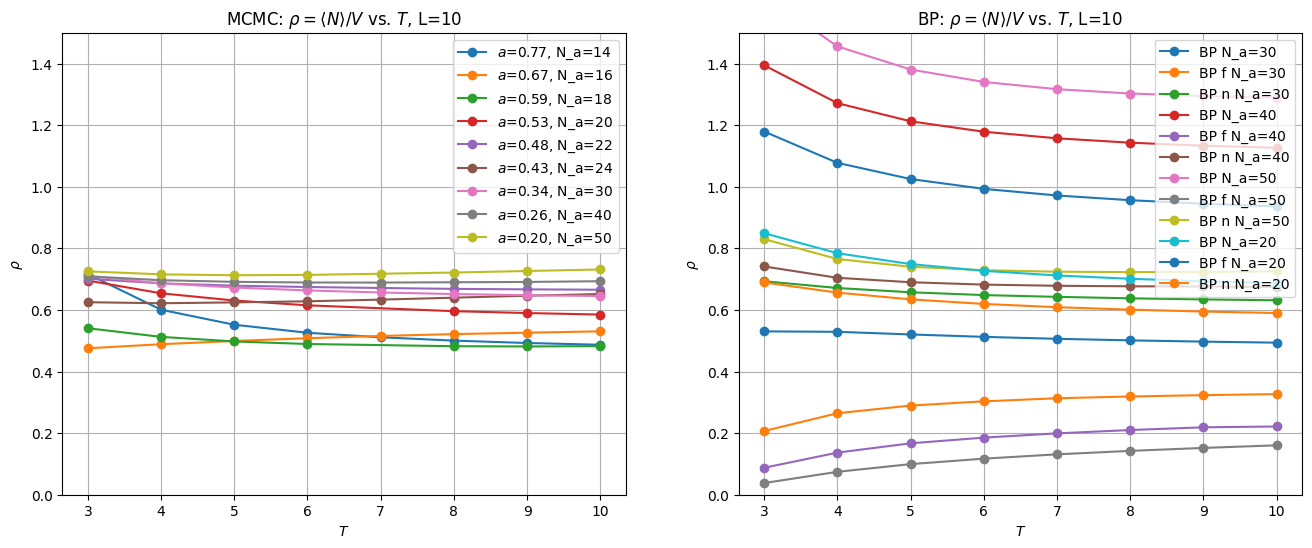

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import re

MC_file = './MC/Results/2DLJ_occ_L=10_results_pbc.txt'

# Read from MC_file
L = 10

f = open(MC_file, "r")
lines = f.readlines()
f.close()

N_a_T_density_dict_MC = {} # {N_a: {T: density}}

for line_ind in range(len(lines)):
    pattern = r'N_a=([\w\.\-+e]+)'
    matches = re.findall(pattern, lines[line_ind])
    if matches:
        N_a = int(matches[0])
        if N_a not in N_a_T_density_dict_MC:
            N_a_T_density_dict_MC[N_a] = {}
        # print(N_a_T_density_dict_MC)
        pattern = r'T=([\w\.\-+e]+)'
        data_string = lines[line_ind+1]
        matches = re.findall(pattern, data_string)
        if matches:
            T = float(matches[0])
        density_pattern = r'Density = ([\w\.\-+e]+)'
        matches = re.findall(density_pattern, data_string)
        if matches:
            density = float(matches[0])
            N_a_T_density_dict_MC[N_a][T] = density
    
print(N_a_T_density_dict_MC)

# Read from BP_file

BP_file = './BP/Results/2D_BP_L=10.txt'

f = open(BP_file, "r")
lines = f.readlines()
f.close()

N_a_T_density_dict_BP = {} # {N_a: {T: [BP_density, BP_fixed_indice_density, BP_surronding_indice_density, BP_naive_density]}}

for line_ind in range(len(lines)):
    N_a_pattern = r'N_a=([\w\.\-+e]+)'
    matches = re.findall(N_a_pattern, lines[line_ind])

    if matches:
        N_a = int(matches[0])
        if N_a not in N_a_T_density_dict_BP:
            N_a_T_density_dict_BP[N_a] = {}
        # print(N_a_T_density_dict_MC)
        T_pattern = r'T=([\w\.\-+e]+)'
        data_string = lines[line_ind]
        matches = re.findall(T_pattern, data_string)
        if matches:
            T = float(matches[0])
        BP_density = float(lines[line_ind+1].split('=')[1])
        BP_fixed_indice_density = float(lines[line_ind+2].split('=')[1])
        BP_surronding_indice_density = float(lines[line_ind+3].split('=')[1])
        BP_naive_density = float(lines[line_ind+4].split('=')[1])

        N_a_T_density_dict_BP[N_a][T] = [BP_density, BP_fixed_indice_density, BP_surronding_indice_density, BP_naive_density]

print(N_a_T_density_dict_BP)
        
# plot MC
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
for N_a in N_a_T_density_dict_MC:
    T_list = []
    density_list = []
    for T in N_a_T_density_dict_MC[N_a]:
        T_list.append(T)
        density_list.append(N_a_T_density_dict_MC[N_a][T])
    # sort the data
    idx = np.argsort(T_list)
    T_list = np.array(T_list)[idx]
    density_list = np.array(density_list)[idx]
    ax[0].plot(T_list, density_list, '-o', label=f'$a$={L/(N_a-1):.2f}, N_a={N_a}')
ax[0].set_xlabel(r'$T$')
ax[0].set_ylabel(r'$\rho$')
ax[0].set_ylim([0,1.5])
ax[0].set_title(r'MCMC: $\rho = \langle N\rangle/V$ vs. $T$, L=10')
ax[0].legend()
ax[0].grid()

# plot BP
for N_a in N_a_T_density_dict_BP:
    T_list = []
    densities_list = []
    for T in N_a_T_density_dict_BP[N_a]:
        T_list.append(T)
        densities_list.append(N_a_T_density_dict_BP[N_a][T])
    # sort the data
    idx = np.argsort(T_list)
    T_list = np.array(T_list)[idx]
    densities_list = np.array(densities_list)[idx]
    ax[1].plot(T_list, densities_list[:,0], '-o', label=f'BP N_a={N_a}')
    ax[1].plot(T_list, densities_list[:,1], '-o', label=f'BP f N_a={N_a}')
    # ax[1].plot(T_list, densities_list[:,2], '-o', label=f'BP s N_a={N_a}')
    ax[1].plot(T_list, densities_list[:,3], '-o', label=f'BP n N_a={N_a}')

ax[1].set_xlabel(r'$T$')
ax[1].set_ylabel(r'$\rho$')
ax[1].set_ylim([0,1.5])
ax[1].set_title(r'BP: $\rho = \langle N\rangle/V$ vs. $T$, L=10')
ax[1].legend()
ax[1].grid()

/tmp/ipykernel_366/2938529740.py:33: DeprecationWarning: scipy.gradient is deprecated and will be removed in SciPy 2.0.0, use numpy.gradient instead
  dSdT = scipy.gradient(Entropy, T_tn)
/tmp/ipykernel_366/2938529740.py:58: DeprecationWarning: scipy.gradient is deprecated and will be removed in SciPy 2.0.0, use numpy.gradient instead
  dSdT = scipy.gradient(Entropy_BP, T_tn_BP)


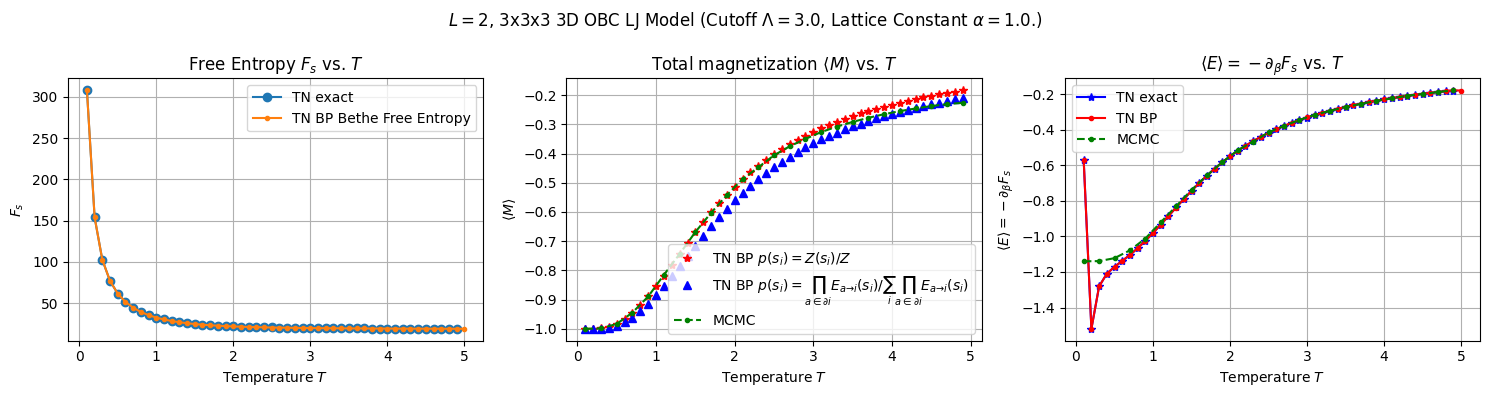

In [112]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

N_a = 3
L = 2

cutoff = 3.0  # Cutoff distance for LJ potential
epsilon = 1.0  # Depth of the potential well/ Energy scale
sigma = 1.0  # Length scale in LJ potential, also the distance at which the potential becomes zero

# TN Exact

# Read from file
f = open(f"./3DLJ_L={L}_N_a={N_a}_exact_results.txt", "r")
lines = f.readlines()
f.close()


# Extract data
T_tn = []
Entropy = []
# M = []

for line in lines:
    line_list = line.split(',')
    T_tn.append(float(line_list[0].split('=')[1]))
    Entropy.append(float(line_list[1].split('=')[1].split('\n')[0]))

# Compute the numerical derivative of the entropy with respect to temperature
T_tn = np.array(T_tn)
Entropy = np.array(Entropy)
dSdT = scipy.gradient(Entropy, T_tn)
T_sq = T_tn**2

numerical_E = T_sq * dSdT / N_a**3


# TN BP

# Read from file
f = open(f"./3DLJ_L={L}_N_a={N_a}_BP_results.txt", "r")
lines = f.readlines()
f.close()

# Extract data
T_tn_BP = []
Entropy_BP = []

for line in lines:
    line_list = line.split(',')
    T_tn_BP.append(float(line_list[0].split('=')[1]))
    Entropy_BP.append(float(line_list[1].split('=')[1].split('\n')[0]))

# Compute the numerical derivative of the entropy with respect to temperature
T_tn_BP = np.array(T_tn_BP)
Entropy_BP = np.array(Entropy_BP)
dSdT = scipy.gradient(Entropy_BP, T_tn_BP)
T_sq = T_tn_BP**2

numerical_E_BP = T_sq * dSdT / N_a**3

# Magnetization
# Read from file
f = open(f"./Mag_3DLJ_L={L}_N_a={N_a}_BP_results.txt", "r")
lines = f.readlines()
f.close()

T_mag_BP = []
M_BP = []
M_BP_from_messages = []

for line in lines:
    line_list = line.split('\n')
    if line_list[0] != '':
        T_mag_BP.append(float(line_list[0].split(',')[0].split('=')[1]))
        M_BP.append(float(line_list[0].split(',')[1].split('=')[1]))
        M_BP_from_messages.append(float(line_list[0].split(',')[2].split('=')[1]))
    



# MC

# Read from file
f = open(f"./MC/3DLJ_L={L}_N_a={N_a}_results.txt", "r")
lines = f.readlines()
f.close()


# Extract data
T = []
E = []
M = []

for line in lines:
    if line.split('=')[0] == 'T':
        T.append(float(line.split('=')[1]))
    elif line.split(' ')[0] == 'Energy':
        E.append(float(line.split(' ')[-1]))
    elif line.split(' ')[0] == 'Total':
        M.append(float(line.split(' ')[-1]))


# Plot
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax[0].plot(T_tn, Entropy, 'o-', label='TN exact')
ax[0].plot(T_tn_BP, Entropy_BP, '.-', label='TN BP Bethe Free Entropy')
ax[0].set_xlabel(r'Temperature $T$')
ax[0].set_ylabel(r'$F_s$')
ax[0].set_title(r'Free Entropy $F_s$ vs. $T$')
ax[0].legend()

ax[2].plot(T_tn, numerical_E, '*-', label='TN exact',color='b')
ax[2].plot(T_tn_BP, numerical_E_BP, '.-', label='TN BP',color='r')
ax[2].plot(T, E, '.--', label='MCMC',color='g')
ax[2].set_xlabel(r'Temperature $T$')
ax[2].set_ylabel(r'$\langle E\rangle = -\partial_\beta F_s$')
ax[2].set_title(r'$\langle E\rangle = -\partial_\beta F_s$ vs. $T$')
ax[2].legend()

ax[1].set_xlabel(r'Temperature $T$')
ax[1].set_ylabel(r'$\langle M\rangle$')
ax[1].set_title(r'Total magnetization $\langle M\rangle$ vs. $T$')

# Plot the BP magnetization
ax[1].plot(T_mag_BP, M_BP, '*', color='r', label=r'TN BP $p(s_i)=Z(s_i)/Z$')
ax[1].plot(T_mag_BP, M_BP_from_messages, '^', color='b', label=r'TN BP $p(s_i)=\prod_{a \in \partial i} E_{a\to i}(s_i)/\sum_i \prod_{a \in \partial i} E_{a\to i}(s_i)$')
ax[1].plot(T, -1*np.array(M), '.--', color='g', label='MCMC')
ax[1].legend(loc='lower right')

ax[0].grid()
ax[2].grid()
ax[1].grid()

# Add title
fig.suptitle(rf'$L={L}$, {N_a}x{N_a}x{N_a} 3D OBC LJ Model (Cutoff $\Lambda = 3.0$, Lattice Constant $\alpha={L/(N_a-1)}$.)')

plt.tight_layout()
plt.savefig(f'./L={L}_{N_a}x{N_a}x{N_a}_MC_BP.pdf')
plt.show()


/tmp/ipykernel_366/313571512.py:30: DeprecationWarning: scipy.gradient is deprecated and will be removed in SciPy 2.0.0, use numpy.gradient instead
  dSdT = scipy.gradient(Entropy_BP, T_tn_BP)


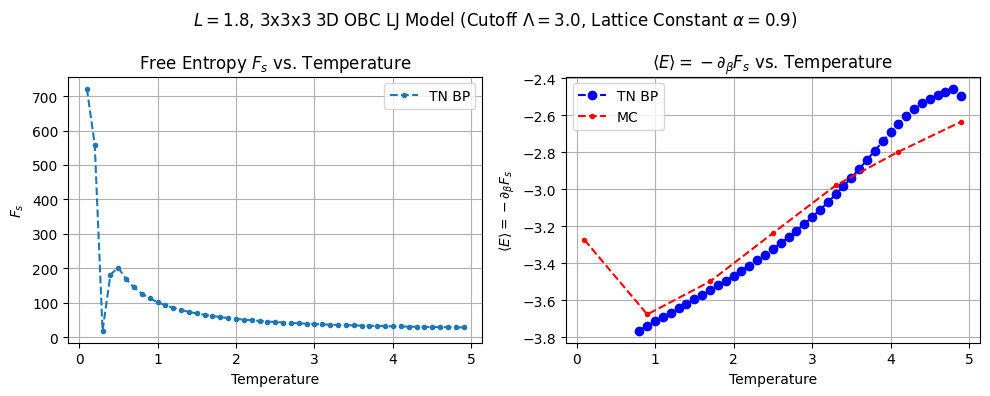

In [194]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

a=0.9
N_a = 3
L = a*(N_a-1)

# TN BP

# Read from file
f = open(f"./3DLJ_L={L}_N_a={N_a}_BP_results.txt", "r")
lines = f.readlines()
f.close()


# Extract data
T_tn_BP = []
Entropy_BP = []
M = []

for line in lines:
    line_list = line.split(',')
    T_tn_BP.append(float(line_list[0].split('=')[1]))
    Entropy_BP.append(float(line_list[1].split('=')[1].split('\n')[0]))

# Compute the numerical derivative of the entropy with respect to temperature
T_tn_BP = np.array(T_tn_BP)
Entropy_BP = np.array(Entropy_BP)
dSdT = scipy.gradient(Entropy_BP, T_tn_BP)
T_sq = T_tn_BP**2
numerical_E_BP = T_sq * dSdT / N_a**3



# MC

# Read from file
f = open(f"./MC/3DLJ_L={L}_N_a={N_a}_results.txt", "r")
lines = f.readlines()
f.close()


# Extract data
T = []
E = []
M = []

for line in lines:
    if line.split('=')[0] == 'T':
        T.append(float(line.split('=')[1]))
    elif line.split(' ')[0] == 'Energy':
        E.append(float(line.split(' ')[-1]))
    elif line.split(' ')[0] == 'Total':
        M.append(float(line.split(' ')[-1]))



# Plot
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
# ax[0].plot(T_tn_e, Entropy_e, 'o-', label='TN exact')
ax[0].plot(T_tn_BP, Entropy_BP, '.--', label='TN BP')
ax[0].set_xlabel('Temperature')
ax[0].set_ylabel(r'$F_s$')
ax[0].set_title(r'Free Entropy $F_s$ vs. Temperature')
ax[0].legend()

n_start = 7
# ax[1].plot(T_tn, numerical_E, '*-', label='TN exact')
ax[1].plot(T_tn_BP[n_start:], numerical_E_BP[n_start:], 'o--', label='TN BP',color='b')
# ax[1].plot(T_tn_e, numerical_E_e, '.-', label='TN exact')
ax[1].plot(T, E, '.--', label='MC',color='r')
ax[1].set_xlabel('Temperature')
ax[1].set_ylabel(r'$\langle E\rangle = -\partial_\beta F_s$')
ax[1].set_title(r'$\langle E\rangle = -\partial_\beta F_s$ vs. Temperature')
ax[1].legend()

ax[0].grid()
ax[1].grid()

# Add title
fig.suptitle(rf'$L={L}$, {N_a}x{N_a}x{N_a} 3D OBC LJ Model (Cutoff $\Lambda = 3.0$, Lattice Constant $\alpha={L/(N_a-1)}$)')

plt.tight_layout()
plt.show()


/tmp/ipykernel_366/1980553012.py:29: DeprecationWarning: scipy.gradient is deprecated and will be removed in SciPy 2.0.0, use numpy.gradient instead
  dSdT = scipy.gradient(Entropy_BP, T_tn_BP)
/tmp/ipykernel_366/1980553012.py:53: DeprecationWarning: scipy.gradient is deprecated and will be removed in SciPy 2.0.0, use numpy.gradient instead
  dSdT = scipy.gradient(Entropy_e, T_tn_e)


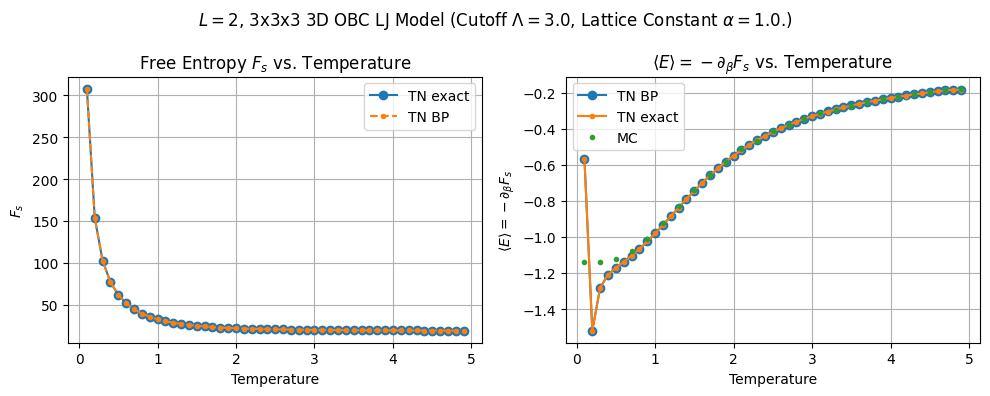

In [181]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

N_a = 3
L = 2

# TN BP

# Read from file
f = open(f"./3DLJ_L={L}_N_a={N_a}_BP_results.txt", "r")
lines = f.readlines()
f.close()


# Extract data
T_tn_BP = []
Entropy_BP = []
M = []

for line in lines:
    line_list = line.split(',')
    T_tn_BP.append(float(line_list[0].split('=')[1]))
    Entropy_BP.append(float(line_list[1].split('=')[1].split('\n')[0]))

# Compute the numerical derivative of the entropy with respect to temperature
T_tn_BP = np.array(T_tn_BP)
Entropy_BP = np.array(Entropy_BP)
dSdT = scipy.gradient(Entropy_BP, T_tn_BP)
T_sq = T_tn_BP**2
numerical_E_BP = T_sq * dSdT / N_a**3

# TN BP

# Read from file
f = open(f"./3DLJ_L={L}_N_a={N_a}_exact_results.txt", "r")
lines = f.readlines()
f.close()


# Extract data
T_tn_e = []
Entropy_e = []

for line in lines:
    line_list = line.split(',')
    T_tn_e.append(float(line_list[0].split('=')[1]))
    Entropy_e.append(float(line_list[1].split('=')[1].split('\n')[0]))

# Compute the numerical derivative of the entropy with respect to temperature
T_tn_e = np.array(T_tn_e)
Entropy_e = np.array(Entropy_e)
dSdT = scipy.gradient(Entropy_e, T_tn_e)
T_sq = T_tn_e**2
numerical_E_e = T_sq * dSdT / N_a**3



# MC

# Read from file
f = open(f"./MC/3DLJ_L={L}_N_a={N_a}_results.txt", "r")
lines = f.readlines()
f.close()


# Extract data
T = []
E = []
M = []

for line in lines:
    if line.split('=')[0] == 'T':
        T.append(float(line.split('=')[1]))
    elif line.split(' ')[0] == 'Energy':
        E.append(float(line.split(' ')[-1]))
    elif line.split(' ')[0] == 'Total':
        M.append(float(line.split(' ')[-1]))



# Plot
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(T_tn_e, Entropy_e, 'o-', label='TN exact')
ax[0].plot(T_tn_BP, Entropy_BP, '.--', label='TN BP')
ax[0].set_xlabel('Temperature')
ax[0].set_ylabel(r'$F_s$')
ax[0].set_title(r'Free Entropy $F_s$ vs. Temperature')
ax[0].legend()


# ax[1].plot(T_tn, numerical_E, '*-', label='TN exact')
ax[1].plot(T_tn_BP, numerical_E_BP, 'o-', label='TN BP')
ax[1].plot(T_tn_e, numerical_E_e, '.-', label='TN exact')
ax[1].plot(T, E, '.', label='MC')
ax[1].set_xlabel('Temperature')
ax[1].set_ylabel(r'$\langle E\rangle = -\partial_\beta F_s$')
ax[1].set_title(r'$\langle E\rangle = -\partial_\beta F_s$ vs. Temperature')
ax[1].legend()

ax[0].grid()
ax[1].grid()

# Add title
fig.suptitle(rf'$L={L}$, {N_a}x{N_a}x{N_a} 3D OBC LJ Model (Cutoff $\Lambda = 3.0$, Lattice Constant $\alpha={L/(N_a-1)}$.)')

plt.tight_layout()
plt.show()


/tmp/ipykernel_366/1000157316.py:29: DeprecationWarning: scipy.gradient is deprecated and will be removed in SciPy 2.0.0, use numpy.gradient instead
  dSdT = scipy.gradient(Entropy_BP, T_tn_BP)


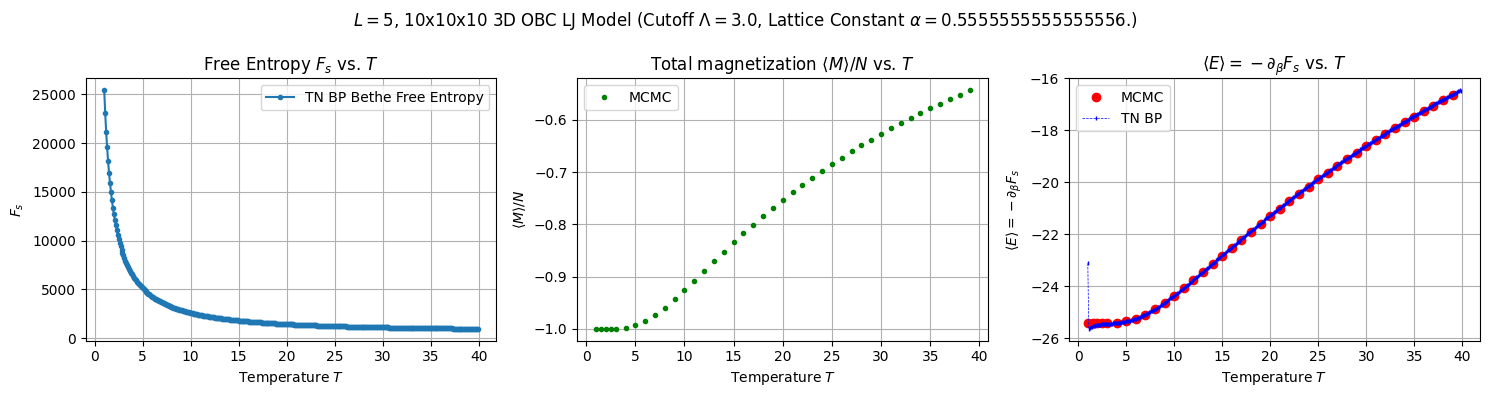

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

N_a = 10
L = 5

# TN BP

# Read from file
f = open(f"./3DLJ_L={L}_N_a={N_a}_BP_results.txt", "r")
lines = f.readlines()
f.close()


# Extract data
T_tn_BP = []
Entropy_BP = []
M = []

for line in lines:
    line_list = line.split(',')
    T_tn_BP.append(float(line_list[0].split('=')[1]))
    Entropy_BP.append(float(line_list[1].split('=')[1].split('\n')[0]))

# Compute the numerical derivative of the entropy with respect to temperature
T_tn_BP = np.array(T_tn_BP)
Entropy_BP = np.array(Entropy_BP)
dSdT = scipy.gradient(Entropy_BP, T_tn_BP)
T_sq = T_tn_BP**2
numerical_E_BP = T_sq * dSdT / N_a**3

# # TN Exact

# # Read from file
# f = open(f"./3DLJ_L={L}_N_a={N_a}_BP_results.txt", "r")
# lines = f.readlines()
# f.close()


# # Extract data
# T_tn = []
# Entropy = []
# M = []

# for line in lines:
#     line_list = line.split(',')
#     T_tn.append(float(line_list[0].split('=')[1]))
#     Entropy.append(float(line_list[1].split('=')[1].split('\n')[0]))

# # Compute the numerical derivative of the entropy with respect to temperature
# T_tn = np.array(T_tn)
# Entropy = np.array(Entropy)
# dSdT = scipy.gradient(Entropy, T_tn)
# T_sq = T_tn**2

# numerical_E = T_sq * dSdT / N_a**3


# MC

# Read from file
f = open(f"./MC/3DLJ_L={L}_N_a={N_a}_results.txt", "r")
lines = f.readlines()+"""
T=20.0
Energy Expectation Value: -21.30120335301263
Total Magnetization Expectation Value: 0.7532500000000006
T=21.0
Energy Expectation Value: -21.010450816917785
Total Magnetization Expectation Value: 0.7386056000000015
T=22.0
Energy Expectation Value: -20.720092918385486
Total Magnetization Expectation Value: 0.7243920000000023
T=23.0
Energy Expectation Value: -20.44069359934478
Total Magnetization Expectation Value: 0.7107280000000038
T=24.0
Energy Expectation Value: -20.165975407453235
Total Magnetization Expectation Value: 0.6976264000000034
T=6.0
Energy Expectation Value: -25.24576626786827
Total Magnetization Expectation Value: 0.9852135999999904
T=25.0
Energy Expectation Value: -19.888879807588193
Total Magnetization Expectation Value: 0.6846600000000005
T=7.0
Energy Expectation Value: -25.091353468074395
Total Magnetization Expectation Value: 0.9739916000000068
T=26.0
Energy Expectation Value: -19.627372665690093
Total Magnetization Expectation Value: 0.6725036000000024
T=8.0
Energy Expectation Value: -24.886555591403464
Total Magnetization Expectation Value: 0.9597620000000087
T=27.0
Energy Expectation Value: -19.366105771914793
Total Magnetization Expectation Value: 0.6603767999999968
T=9.0
Energy Expectation Value: -24.642402472193425
Total Magnetization Expectation Value: 0.9433628000000064
T=28.0
Energy Expectation Value: -19.112376986416713
Total Magnetization Expectation Value: 0.6488215999999976
T=10.0
Energy Expectation Value: -24.371031562657393
Total Magnetization Expectation Value: 0.9259560000000023
T=29.0
Energy Expectation Value: -18.86521863437133
Total Magnetization Expectation Value: 0.637916800000002
T=11.0
Energy Expectation Value: -24.081345277217647
Total Magnetization Expectation Value: 0.907685199999999
T=30.0
Energy Expectation Value: -18.614854464689987
Total Magnetization Expectation Value: 0.6266463999999995
T=12.0
Energy Expectation Value: -23.775103207646698
Total Magnetization Expectation Value: 0.8890779999999999
T=31.0
Energy Expectation Value: -18.37786372749181
Total Magnetization Expectation Value: 0.6164316000000003
T=13.0
Energy Expectation Value: -23.465051997034315
Total Magnetization Expectation Value: 0.8707563999999997
T=32.0
Energy Expectation Value: -18.14110587960606
Total Magnetization Expectation Value: 0.6061560000000004
T=14.0
Energy Expectation Value: -23.150593557755233
Total Magnetization Expectation Value: 0.8524912000000042
T=33.0
Energy Expectation Value: -17.916090645782063
Total Magnetization Expectation Value: 0.5964520000000001
T=15.0
Energy Expectation Value: -22.834125721997655
Total Magnetization Expectation Value: 0.8346003999999982
T=34.0
Energy Expectation Value: -17.692567986796625
Total Magnetization Expectation Value: 0.5868943999999984
T=16.0
Energy Expectation Value: -22.520398726989434
Total Magnetization Expectation Value: 0.8172895999999973
T=35.0
Energy Expectation Value: -17.470822822943177
Total Magnetization Expectation Value: 0.5776415999999984
T=17.0
Energy Expectation Value: -22.21193103891956
Total Magnetization Expectation Value: 0.8007583999999952
T=36.0
Energy Expectation Value: -17.260953826862913
Total Magnetization Expectation Value: 0.5688347999999971
T=18.0
Energy Expectation Value: -21.903106904737594
Total Magnetization Expectation Value: 0.7842695999999965
T=37.0
Energy Expectation Value: -17.047231404826096
Total Magnetization Expectation Value: 0.5599615999999976
T=19.0
Energy Expectation Value: -21.597628005220148
Total Magnetization Expectation Value: 0.768391599999998
T=38.0
Energy Expectation Value: -16.841622696087327
Total Magnetization Expectation Value: 0.5515535999999961
T=39.0
Energy Expectation Value: -16.639071963452388
Total Magnetization Expectation Value: 0.5432991999999958""".split('\n')
f.close()


# Extract data
T = []
E = []
M = []

for line in lines:
    if line.split('=')[0] == 'T':
        T.append(float(line.split('=')[1]))
    elif line.split(' ')[0] == 'Energy':
        E.append(float(line.split(' ')[-1]))
    elif line.split(' ')[0] == 'Total':
        M.append(float(line.split(' ')[-1]))



# Plot
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
# ax[0].plot(T_tn, Entropy, 'o-', label='TN exact')
ax[0].plot(T_tn_BP, Entropy_BP, '.-', label='TN BP Bethe Free Entropy')
ax[0].set_xlabel(r'Temperature $T$')
ax[0].set_ylabel(r'$F_s$')
ax[0].set_title(r'Free Entropy $F_s$ vs. $T$')
ax[0].legend()


# ax[2].plot(T_tn, numerical_E, '|-', label='TN exact')
ax[2].plot(T, E, 'o', label='MCMC',color='r')
ax[2].plot(T_tn_BP, numerical_E_BP, '|--', label='TN BP',color='b',linewidth=0.5,markersize=3)
ax[2].set_xlabel(r'Temperature $T$')
ax[2].set_ylabel(r'$\langle E\rangle = -\partial_\beta F_s$')
ax[2].set_title(r'$\langle E\rangle = -\partial_\beta F_s$ vs. $T$')
ax[2].legend()

ax[1].plot(T, np.array(M)*-1, '.', color='g', label='MCMC')
ax[1].set_xlabel(r'Temperature $T$')
ax[1].set_ylabel(r'$\langle M\rangle/N$')
ax[1].set_title(r'Total magnetization $\langle M\rangle /N$ vs. $T$')
ax[1].legend()



ax[0].grid()
ax[2].grid()
ax[1].grid()

# Add title
fig.suptitle(rf'$L={L}$, {N_a}x{N_a}x{N_a} 3D OBC LJ Model (Cutoff $\Lambda = 3.0$, Lattice Constant $\alpha={L/(N_a-1)}$.)')

plt.tight_layout()
plt.savefig(f'./L={L}_{N_a}x{N_a}x{N_a}_MC_BP.pdf')
plt.show()


## Occupation number basis

/tmp/ipykernel_366/659253006.py:29: DeprecationWarning: scipy.gradient is deprecated and will be removed in SciPy 2.0.0, use numpy.gradient instead
  dSdT = scipy.gradient(Entropy_BP, T_tn_BP)
/tmp/ipykernel_366/659253006.py:50: DeprecationWarning: scipy.gradient is deprecated and will be removed in SciPy 2.0.0, use numpy.gradient instead
  dSdT = scipy.gradient(Entropy_BP_spin, T_tn_BP_spin)
/tmp/ipykernel_366/659253006.py:96: DeprecationWarning: scipy.gradient is deprecated and will be removed in SciPy 2.0.0, use numpy.gradient instead
  dSdT = scipy.gradient(Entropy_e, T_tn_e)


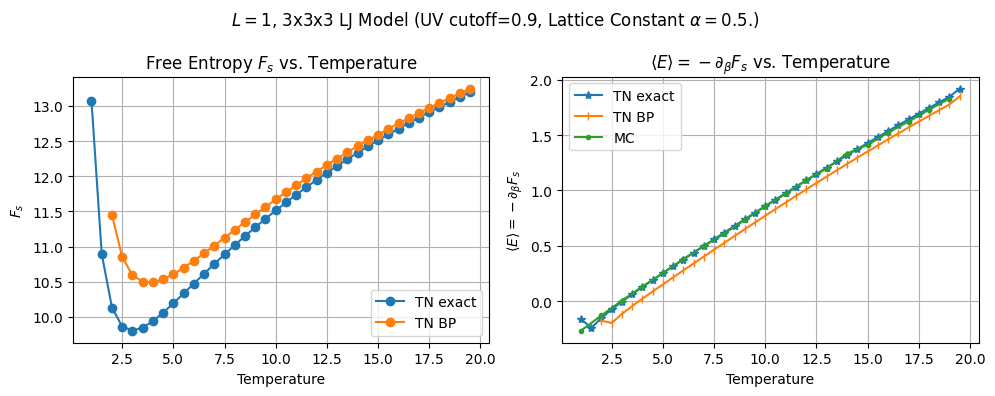

In [71]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

L=1
N_a=3

# TN BP

# Read from file
f = open(f"./3DLJ_occ_L={L}_N_a={N_a}_BP_cutoff_results.txt", "r")
lines = f.readlines()
f.close()


# Extract data
T_tn_BP = []
Entropy_BP = []
M = []

for line in lines:
    if line.split(',')[1].split('=')[0] == ' Entropy ':
        Entropy_BP.append(float(line.split(',')[1].split('=')[1].split('\n')[0]))
        T_tn_BP.append(float(line.split(',')[0].split('=')[1]))

# Compute the numerical derivative of the entropy with respect to temperature
T_tn_BP = np.array(T_tn_BP)
Entropy_BP = np.array(Entropy_BP)
dSdT = scipy.gradient(Entropy_BP, T_tn_BP)
T_sq = T_tn_BP**2
numerical_E_BP = T_sq * dSdT / N_a**3

# TN BP spin basis
f = open(f"./3DLJ_L={L}_N_a={N_a}_BP_results.txt", "r")
lines = f.readlines()
f.close()

# Extract data
T_tn_BP_spin = []
Entropy_BP_spin = []

for line in lines:
    if line.split(',')[1].split('=')[0] == ' Entropy ':
        Entropy_BP_spin.append(float(line.split(',')[1].split('=')[1].split('\n')[0]))
        T_tn_BP_spin.append(float(line.split(',')[0].split('=')[1]))

# Compute the numerical derivative of the entropy with respect to temperature
T_tn_BP_spin = np.array(T_tn_BP_spin)
Entropy_BP_spin = np.array(Entropy_BP_spin)
dSdT = scipy.gradient(Entropy_BP_spin, T_tn_BP_spin)
T_sq = T_tn_BP_spin**2
numerical_E_BP_spin = T_sq * dSdT / N_a**3


# MC

# Read from file
f = open(f"./MC/3DLJ_occ_L={L}_N_a={N_a}_cutoff_results.txt", "r")
lines = f.readlines()
f.close()


# Extract data
T = []
E = []
M = []

for line in lines:
    if line.split('=')[0] == 'T':
        T.append(float(line.split('=')[1]))
    elif line.split(' ')[0] == 'Energy':
        E.append(float(line.split(' ')[-1]))
    elif line.split(' ')[0] == 'Total':
        M.append(float(line.split(' ')[-1]))

# TN Exact

# Read from file
f = open(f"./3DLJ_occ_L={L}_N_a={N_a}_Exact_cutoff_results.txt", "r")
lines = f.readlines()
f.close()


# Extract data
T_tn_e = []
Entropy_e = []

for line in lines:
    if line.split(',')[1].split('=')[0] == ' Entropy ':
        Entropy_e.append(float(line.split(',')[1].split('=')[1].split('\n')[0]))
        T_tn_e.append(float(line.split(',')[0].split('=')[1]))

# Compute the numerical derivative of the entropy with respect to temperature
T_tn_e = np.array(T_tn_e)
Entropy_e = np.array(Entropy_e)
dSdT = scipy.gradient(Entropy_e, T_tn_e)
T_sq = T_tn_e**2
numerical_E_e = T_sq * dSdT / N_a**3





# Plot
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(T_tn_e, Entropy_e, 'o-', label='TN exact')
ax[0].plot(T_tn_BP, Entropy_BP, 'o-', label='TN BP')
ax[0].set_xlabel('Temperature')
ax[0].set_ylabel(r'$F_s$')
ax[0].set_title(r'Free Entropy $F_s$ vs. Temperature')
ax[0].legend()

ax[1].plot(T_tn_e, numerical_E_e, '*-', label='TN exact')
ax[1].plot(T_tn_BP, numerical_E_BP, '|-', label='TN BP')
ax[1].plot(T, E, '.-', label='MC')
ax[1].set_xlabel('Temperature')
ax[1].set_ylabel(r'$\langle E\rangle = -\partial_\beta F_s$')
ax[1].set_title(r'$\langle E\rangle = -\partial_\beta F_s$ vs. Temperature')
ax[1].legend()

ax[0].grid()
ax[1].grid()

# Add title
fig.suptitle(rf'$L={L}$, {N_a}x{N_a}x{N_a} LJ Model (UV cutoff=0.9, Lattice Constant $\alpha={L/(N_a-1)}$.)')

plt.tight_layout()
plt.show()


/tmp/ipykernel_366/4186747818.py:36: DeprecationWarning: scipy.gradient is deprecated and will be removed in SciPy 2.0.0, use numpy.gradient instead
  dSdT = scipy.gradient(Entropy_BP, T_tn_BP)
/tmp/ipykernel_366/4186747818.py:82: DeprecationWarning: scipy.gradient is deprecated and will be removed in SciPy 2.0.0, use numpy.gradient instead
  dSdT = scipy.gradient(Entropy_e, T_tn_e)


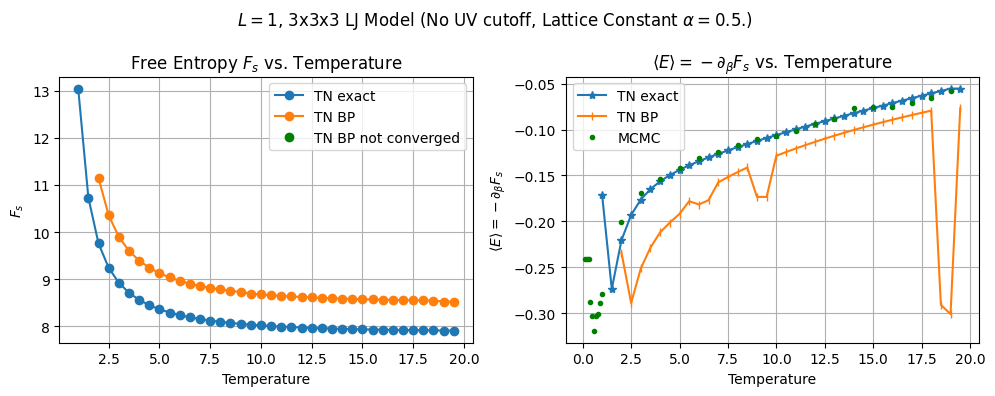

In [84]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

L=1
N_a=3

# TN BP

# Read from file
f = open(f"./3DLJ_occ_L={L}_N_a={N_a}_BP_results.txt", "r")
lines = f.readlines()
f.close()


# Extract data
T_tn_BP = []
T_tn_BP_not_converged = []
Entropy_BP = []
Entropy_BP_not_converged = []

for line in lines:
    if line.split(',')[1].split('=')[0] == ' Entropy ':
        Entropy_BP.append(float(line.split(',')[1].split('=')[1].split('\n')[0]))
        T_tn_BP.append(float(line.split(',')[0].split('=')[1]))
    else:
        T_tn_BP.append(float(line.split(',')[0].split('=')[1]))
        Entropy_BP.append(float(line.split(',')[2].split('=')[1].split('\n')[0]))
        T_tn_BP_not_converged.append(float(line.split(',')[0].split('=')[1]))
        Entropy_BP_not_converged.append(float(line.split(',')[2].split('=')[1].split('\n')[0]))
        

# Compute the numerical derivative of the entropy with respect to temperature
T_tn_BP = np.array(T_tn_BP)
Entropy_BP = np.array(Entropy_BP)
dSdT = scipy.gradient(Entropy_BP, T_tn_BP)
T_sq = T_tn_BP**2
numerical_E_BP = T_sq * dSdT / N_a**3


# MC

# Read from file
f = open(f"./MC/3DLJ_occ_L={L}_N_a={N_a}_results.txt", "r")
lines = f.readlines()
f.close()


# Extract data
T = []
E = []
M = []

for line in lines:
    if line.split('=')[0] == 'T':
        T.append(float(line.split('=')[1]))
    elif line.split(' ')[0] == 'Energy':
        E.append(float(line.split(' ')[-1]))
    elif line.split(' ')[0] == 'Total':
        M.append(float(line.split(' ')[-1]))

# TN Exact

# Read from file
f = open(f"./3DLJ_occ_L={L}_N_a={N_a}_Exact_results.txt", "r")
lines = f.readlines()
f.close()


# Extract data
T_tn_e = []
Entropy_e = []

for line in lines:
    if line.split(',')[1].split('=')[0] == ' Entropy ':
        Entropy_e.append(float(line.split(',')[1].split('=')[1].split('\n')[0]))
        T_tn_e.append(float(line.split(',')[0].split('=')[1]))

# Compute the numerical derivative of the entropy with respect to temperature
T_tn_e = np.array(T_tn_e)
Entropy_e = np.array(Entropy_e)
dSdT = scipy.gradient(Entropy_e, T_tn_e)
T_sq = T_tn_e**2
numerical_E_e = T_sq * dSdT / N_a**3





# Plot
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(T_tn_e, Entropy_e, 'o-', label='TN exact')
ax[0].plot(T_tn_BP, Entropy_BP, 'o-', label='TN BP')
ax[0].plot(T_tn_BP_not_converged, Entropy_BP_not_converged, 'o', color ='g',label='TN BP not converged')
ax[0].set_xlabel('Temperature')
ax[0].set_ylabel(r'$F_s$')
ax[0].set_title(r'Free Entropy $F_s$ vs. Temperature')
ax[0].legend()

ax[1].plot(T_tn_e, numerical_E_e, '*-', label='TN exact')
ax[1].plot(T_tn_BP, numerical_E_BP, '|-', label='TN BP')

ax[1].plot(T, E, '.', label='MCMC',color='g')
ax[1].set_xlabel('Temperature')
ax[1].set_ylabel(r'$\langle E\rangle = -\partial_\beta F_s$')
ax[1].set_title(r'$\langle E\rangle = -\partial_\beta F_s$ vs. Temperature')
ax[1].legend()

ax[0].grid()
ax[1].grid()

# Add title
fig.suptitle(rf'$L={L}$, {N_a}x{N_a}x{N_a} LJ Model (No UV cutoff, Lattice Constant $\alpha={L/(N_a-1)}$.)')

plt.tight_layout()
plt.show()


/tmp/ipykernel_366/1123349773.py:36: DeprecationWarning: scipy.gradient is deprecated and will be removed in SciPy 2.0.0, use numpy.gradient instead
  dSdT = scipy.gradient(Entropy_BP, T_tn_BP)


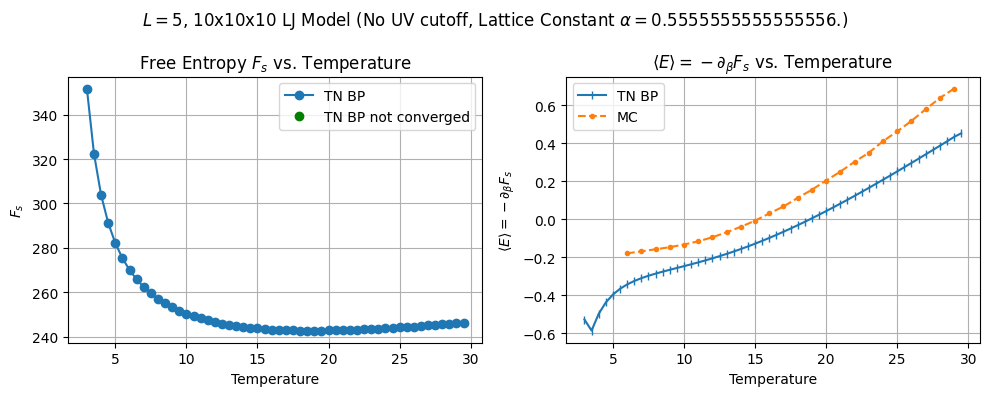

In [115]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

L=5
N_a=10

# TN BP

# Read from file
f = open(f"./3DLJ_occ_L={L}_N_a={N_a}_BP_results.txt", "r")
lines = f.readlines()
f.close()


# Extract data
T_tn_BP = []
T_tn_BP_not_converged = []
Entropy_BP = []
Entropy_BP_not_converged = []

for line in lines:
    if line.split(',')[1].split('=')[0] == ' Entropy ':
        Entropy_BP.append(float(line.split(',')[1].split('=')[1].split('\n')[0]))
        T_tn_BP.append(float(line.split(',')[0].split('=')[1]))
    else:
        T_tn_BP.append(float(line.split(',')[0].split('=')[1]))
        Entropy_BP.append(float(line.split(',')[2].split('=')[1].split('\n')[0]))
        T_tn_BP_not_converged.append(float(line.split(',')[0].split('=')[1]))
        Entropy_BP_not_converged.append(float(line.split(',')[2].split('=')[1].split('\n')[0]))
        

# Compute the numerical derivative of the entropy with respect to temperature
T_tn_BP = np.array(T_tn_BP)
Entropy_BP = np.array(Entropy_BP)
dSdT = scipy.gradient(Entropy_BP, T_tn_BP)
T_sq = T_tn_BP**2
numerical_E_BP = T_sq * dSdT / N_a**3


# MC

# Read from file
f = open(f"./MC/3DLJ_occ_L={L}_N_a={N_a}_results.txt", "r")
lines = f.readlines()
f.close()


# Extract data
T = []
E = []
M = []

for line in lines:
    if line.split('=')[0] == 'T':
        T.append(float(line.split('=')[1]))
    elif line.split(' ')[0] == 'Energy':
        E.append(float(line.split(' ')[-1]))
    elif line.split(' ')[0] == 'Total':
        M.append(float(line.split(' ')[-1]))

# # Spin basis results
# f0 = open(f"./MC/3DLJ_L={L}_N_a={N_a}_results.txt", "r")
# lines = f0.readlines()
# f0.close()

# T_spin = []
# E_spin = []

# for line in lines:
#     if line.split('=')[0] == 'T':
#         T_spin.append(float(line.split('=')[1]))
#     elif line.split(' ')[0] == 'Energy':
#         E_spin.append(float(line.split(' ')[-1]))

# # Compare with occupation number basis results

# zipped_T_E_spin = zip(T_spin, E_spin)
zipped_T_E = zip(T, E)

# T_spin, E_spin = zip(*sorted(zipped_T_E_spin))
T, E = zip(*sorted(zipped_T_E))

# T_spin = list(T_spin)
# E_spin = list(E_spin)
T = list(T)
E = list(E)




# Plot
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
# ax[0].plot(T_tn_e, Entropy_e, 'o-', label='TN exact')
ax[0].plot(T_tn_BP, Entropy_BP, 'o-', label='TN BP')
ax[0].plot(T_tn_BP_not_converged, Entropy_BP_not_converged, 'o', color ='g',label='TN BP not converged')
ax[0].set_xlabel('Temperature')
ax[0].set_ylabel(r'$F_s$')
ax[0].set_title(r'Free Entropy $F_s$ vs. Temperature')
ax[0].legend()

# ax[1].plot(T_tn_e, numerical_E_e, '*-', label='TN exact')
ax[1].plot(T_tn_BP, numerical_E_BP, '|-', label='TN BP')
# ax[1].plot(T_spin, E_spin, '.-', label='MCMC spin basis',color='g')
ax[1].plot(T, E, '.--', label='MC')
ax[1].set_xlabel('Temperature')
ax[1].set_ylabel(r'$\langle E\rangle = -\partial_\beta F_s$')
ax[1].set_title(r'$\langle E\rangle = -\partial_\beta F_s$ vs. Temperature')
ax[1].legend()

ax[0].grid()
ax[1].grid()

# Add title
fig.suptitle(rf'$L={L}$, {N_a}x{N_a}x{N_a} LJ Model (No UV cutoff, Lattice Constant $\alpha={L/(N_a-1)}$.)')

plt.tight_layout()
plt.show()


In [95]:
"""
T=0.01, Entropy = 1941682.4142318552, Converged=True, damping=0.004
T=0.05, Entropy = 335263.63953579473, Converged=True, damping=0.004
T=0.1, Entropy = 134463.9384719512, Converged=True, damping=0.004
T=0.4, Entropy = 4375.910083863756, Converged=True, damping=0.006
"""

'\nT=0.01, Entropy = 1941682.4142318552, Converged=True, damping=0.004\nT=0.05, Entropy = 335263.63953579473, Converged=True, damping=0.004\nT=0.1, Entropy = 134463.9384719512, Converged=True, damping=0.004\nT=0.4, Entropy = 4375.910083863756, Converged=True, damping=0.006\n'

/tmp/ipykernel_366/300955969.py:39: DeprecationWarning: scipy.gradient is deprecated and will be removed in SciPy 2.0.0, use numpy.gradient instead
  dSdT = scipy.gradient(Entropy_BP, T_tn_BP)


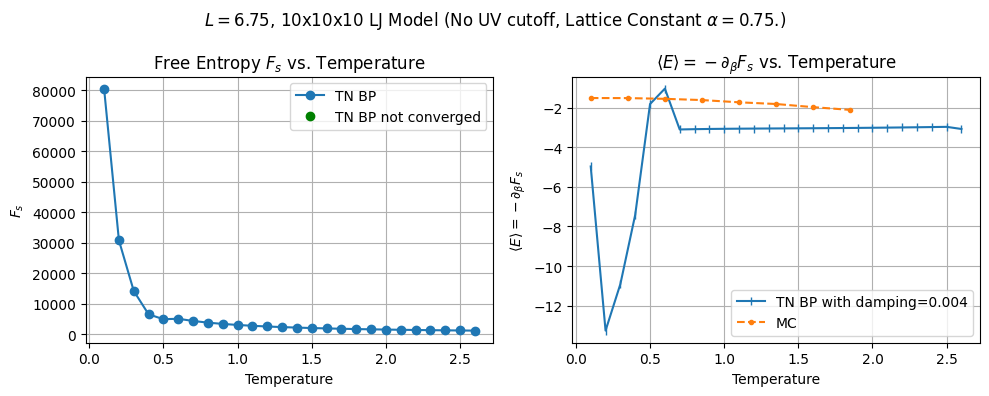

In [176]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.ndimage import gaussian_filter1d

L=6.75
N_a=10

# TN BP

# Read from file
f = open(f"./3DLJ_occ_L={L}_N_a={N_a}_BP_results.txt", "r")
lines = f.readlines()
f.close()


# Extract data
T_tn_BP = []
T_tn_BP_not_converged = []
Entropy_BP = []
Entropy_BP_not_converged = []

for line in lines:
    if line.split(',')[1].split('=')[0] == ' Entropy ':
        Entropy_BP.append(float(line.split(',')[1].split('=')[1].split('\n')[0]))
        T_tn_BP.append(float(line.split(',')[0].split('=')[1]))
    else:
        T_tn_BP.append(float(line.split(',')[0].split('=')[1]))
        Entropy_BP.append(float(line.split(',')[2].split('=')[1].split('\n')[0]))
        T_tn_BP_not_converged.append(float(line.split(',')[0].split('=')[1]))
        Entropy_BP_not_converged.append(float(line.split(',')[2].split('=')[1].split('\n')[0]))
        

# Compute the numerical derivative of the entropy with respect to temperature
T_tn_BP = np.array(T_tn_BP)
Entropy_BP = np.array(Entropy_BP)
# sigma = 2
# Entropy_BP = gaussian_filter1d(Entropy_BP, sigma)
dSdT = scipy.gradient(Entropy_BP, T_tn_BP)
T_sq = T_tn_BP**2
numerical_E_BP = T_sq * dSdT / N_a**3


# MC

# Read from file
f = open(f"./MC/3DLJ_occ_L={L}_N_a={N_a}_results.txt", "r")
lines = f.readlines()
f.close()


# Extract data
T = []
E = []
M = []

for line in lines:
    if line.split('=')[0] == 'T':
        T.append(float(line.split('=')[1]))
    elif line.split(' ')[0] == 'Energy':
        E.append(float(line.split(' ')[-1]))
    elif line.split(' ')[0] == 'Total':
        M.append(float(line.split(' ')[-1]))



# Plot
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
# ax[0].plot(T_tn_e, Entropy_e, 'o-', label='TN exact')
ax[0].plot(T_tn_BP, Entropy_BP, 'o-', label='TN BP')
ax[0].plot(T_tn_BP_not_converged, Entropy_BP_not_converged, 'o', color ='g',label='TN BP not converged')
ax[0].set_xlabel('Temperature')
ax[0].set_ylabel(r'$F_s$')
ax[0].set_title(r'Free Entropy $F_s$ vs. Temperature')
ax[0].legend()

# ax[1].plot(T_tn_e, numerical_E_e, '*-', label='TN exact')
ax[1].plot(T_tn_BP, numerical_E_BP, '|-', label=f'TN BP with damping=0.004')

ax[1].plot(T, E, '.--', label='MC')
ax[1].set_xlabel('Temperature')
ax[1].set_ylabel(r'$\langle E\rangle = -\partial_\beta F_s$')
ax[1].set_title(r'$\langle E\rangle = -\partial_\beta F_s$ vs. Temperature')
ax[1].legend()

ax[0].grid()
ax[1].grid()

# Add title
fig.suptitle(rf'$L={L}$, {N_a}x{N_a}x{N_a} LJ Model (No UV cutoff, Lattice Constant $\alpha={L/(N_a-1)}$.)')

plt.tight_layout()
plt.show()




T=2.7, Entropy = 1137.6051565837727, Converged=True, damping=0
T=2.8000000000000003, Entropy = 1098.759997802954, Converged=True, damping=0
T=2.9000000000000004, Entropy = 901.0483408124379, Converged=True, damping=0.001
T=3.0000000000000004, Entropy = 1029.3379516032535, Converged=True, damping=0
T=3.1, Entropy = 998.235978343751, Converged=True, damping=0
T=3.2, Entropy = 969.243784000318, Converged=True, damping=0
T=3.3000000000000003, Entropy = 942.172216597379, Converged=True, damping=0
T=3.4000000000000004, Entropy = 916.8539125144649, Converged=True, damping=0
T=3.5000000000000004, Entropy = 893.1402034481494, Converged=True, damping=0
T=3.6, Entropy = 870.898540056027, Converged=True, damping=0
T=3.7, Entropy = 850.0103341492409, Converged=True, damping=0
T=3.8000000000000003, Entropy = 830.3691420330672, Converged=True, damping=0
T=3.9000000000000004, Entropy = 811.8791275161907, Converged=True, damping=0
T=4.0, Entropy = 794.4537554546112, Converged=True, damping=0
T=4.1, Entropy = 778.0146763118087, Converged=True, damping=0
T=4.2, Entropy = 762.490769776185, Converged=True, damping=0
T=4.3, Entropy = 747.8173214519351, Converged=True, damping=0
T=4.3999999999999995, Entropy = 733.9353113714737, Converged=True, damping=0
T=4.5, Entropy = 720.7907968799171, Converged=True, damping=0
T=4.6, Entropy = 708.3343754887488, Converged=True, damping=0
T=4.7, Entropy = 696.5207157566491, Converged=True, damping=0
T=4.8, Entropy = 685.3081462518016, Converged=True, damping=0
T=4.9, Entropy = 674.6582942880848, Converged=True, damping=0
T=5.0, Entropy = 664.5357674552182, Converged=True, damping=0
T=5.1, Entropy = 654.9078720675955, Converged=True, damping=0
T=5.2, Entropy = 645.7443635595922, Converged=True, damping=0
T=5.3, Entropy = 637.0172246152785, Converged=True, damping=0
T=5.4, Entropy = 628.7004674391371, Converged=True, damping=0
T=5.5, Entropy = 620.7699571050517, Converged=True, damping=0